In [1]:
import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

In [80]:
# Get data from Quandl and generate some more valuable data from it.
df = quandl.get("WIKI/TSLA")
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Low'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

# Strip out the data we don't want.
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

In [81]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2010-06-29,23.89,42.531357,25.736842,18766300.0
2010-06-30,23.83,30.557940,-7.599845,17187100.0
2010-07-01,21.96,27.873705,-12.160000,8218800.0
2010-07-02,19.20,23.463389,-16.521739,5139800.0
2010-07-06,16.11,26.342388,-19.450000,6866900.0


In [82]:
# Set up our "label" column.
# Label is ML speak for the output.
# In contrast to features, which are the input.
# X => features
# Y => labels
forecast_col = 'Adj. Close'
# We use -99999 so that it will be removed as an outlier by most ML programs
# We can't just pass NaN
df.fillna(value=-999999, inplace=True)
# The length of our forecast is 1% the length of our input
forecast_out = int(math.ceil(0.05 * len(df)))
# Create the output rows
df['label'] = df[forecast_col].shift(-forecast_out)

In [83]:
# Scale the input and output features in the same call, then split them
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

In [84]:
# Drop any remaining NaN
df.dropna(inplace=True)

y = np.array(df['label'])

In [85]:
# Split into training and test sets, run classifier, check confidence
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)

In [86]:
print "Confidence: ", confidence

Confidence:  0.879981751479


In [87]:
# Predict price into the future
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan

In [88]:
import calendar
# Fixup data frame for plotting
last_date = df.iloc[-1].name
last_unix = calendar.timegm(last_date.utctimetuple())
one_day = 86400
next_unix = last_unix + one_day

In [89]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]


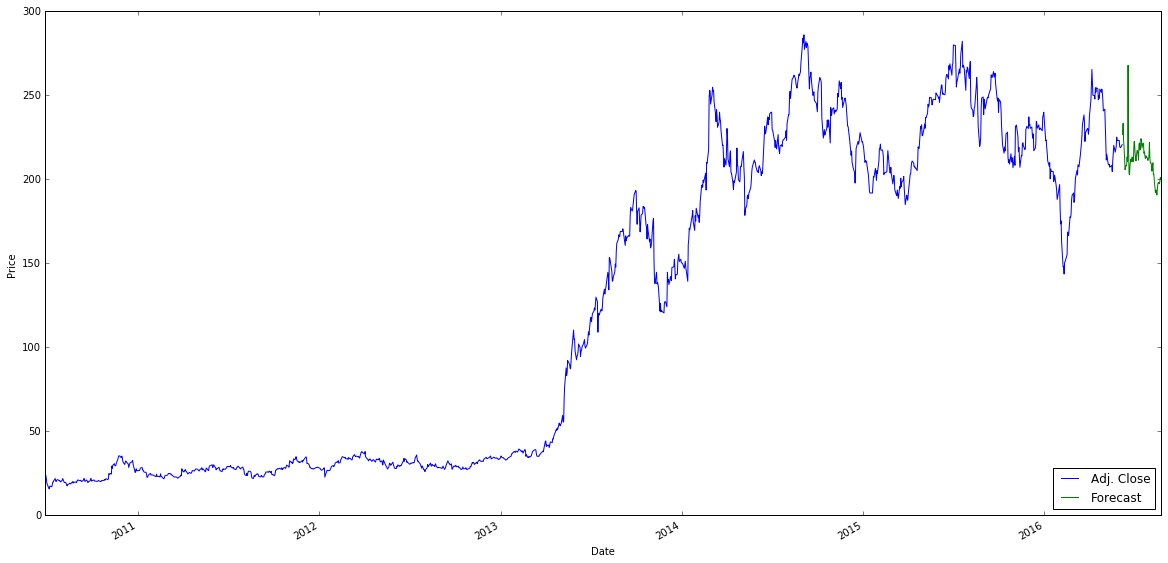

In [90]:
plt.figure(figsize=(20,10))
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show("plot.jpg")